# Einleitung

Das folgende Jupyter Notebook wurde so vorbereitet, dass es unter Google Colab problemlos durchläuft.

Es zeigt, wie man einen Objektdetektor für eigene Objektkategorien schreiben kann.

Möchte man es offline auf dem eigenen Rechner ausführen sind noch einige Dinge zu installieren. Diese werden an den entsprechenden Stellen erwähnt.


Dieses Notebook wurde sehr von folgendem Blogbeitrag inspiriert: 

[How to train an object detection model easy for free](https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/)

# Konfiguration des Modells und der Hyperparameter

Im folgenden legen wir verschiedene Dinge fest:

  - welches Objektdetektormodell soll verwendet werden? `selected_model`
  - wieviele Schritte soll trainiert werden? `num_steps`
  - wie oft soll das Modell während des Trainings evaluiert werden? `num_eval_steps`

Andere Modelle sind im *Tensorflow detection model zoo* hier verfügbar:

https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models

Konfigurationsdateien für die Trainingspipeline sind hier verfügbar:https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs

In [0]:
# If you forked the repository, you can replace the link.
repo_url = 'https://github.com/Tony607/object_detection_demo'

# Number of training steps.
num_steps = 10000  # 200000

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

# Ausführen von Shell-Kommandos

Im folgenden ist es notwendig noch ein paar Tools aufzurufen.

Dazu ist es möglich aus einem Jupyter Notebook direkt Befehle auf der Shell abzusetzen. Man muss dazu nur ein `!` vorabstellen.

In [0]:
%cd /content
!ls

/content
sample_data


In [0]:
!pwd

/content


In [0]:
!echo "Hallo BVKurs!"

Hallo BVKurs!


# Klonen des `object_detection_demo` Repository

Das `object_detection_demo` Sourcecodeprojekt enthält viele nützliche Hilfsklassen und Trainingsdaten, die wir im folgenden verwenden werden.

In [0]:
repo_url

'https://github.com/Tony607/object_detection_demo'

In [0]:
import os
%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

/content


In [0]:
repo_dir_path

'/content/object_detection_demo'

Wir clonen jetzt das Repository, um an den Code und die Trainingsdaten zu kommen.

Das Clonen erfolgt dabei mit der `git`-Sourcecodeversionsverwaltung.

In [0]:
!git clone {repo_url}
%cd {repo_dir_path}
!git pull

Cloning into 'object_detection_demo'...
remote: Enumerating objects: 124, done.
remote: Total 124 (delta 0), reused 0 (delta 0), pack-reused 124
Receiving objects: 100% (124/124), 11.16 MiB | 1.93 MiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/object_detection_demo
Already up to date.


# Bereitstellung der Trainingsdaten

Wir haben durch das Klonen des Repositories bereits einige Beispieldaten enthalten.

Schauen Sie mal unter `Files` in das Verzeichnis

`content/object_dectection_demo/data/`

nach Bildern. Ihnen wird auffallen, dass dort auch `.xml` Dateien liegen. Dabei handelt es sich um die Annotationsdaten, d.h. wo ist welches Objekt.

Die Bilder wurden mit dem Tool `labelImg` annotiert. Sie können dies für eigene Bilder + Objektkategorien selber mit dem Tool machen:

https://tzutalin.github.io/labelImg/

Das Annotationsformat ist das `Pascal VOC` Format, das als XML-Datei fast selbsterklärend ist:

    <annotation>
      <folder>images</folder>
      <filename>0.jpg</filename>
      <path>E:\Learning_Resources\Deep_learning\my_data_sets\DATASETS_IMAGE\object_detection_demo\images\0.jpg</path>
      <source>
        <database>Unknown</database>
      </source>
      <size>
        <width>800</width>
        <height>600</height>
        <depth>3</depth>
      </size>
      <segmented>0</segmented>
      <object>
        <name>date</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
          <xmin>101</xmin>
          <ymin>117</ymin>
          <xmax>240</xmax>
          <ymax>286</ymax>
        </bndbox>
      </object>
      <object>
        <name>date</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
          <xmin>322</xmin>
          <ymin>321</ymin>
          <xmax>463</xmax>
          <ymax>422</ymax>
        </bndbox>
      </object>

      ...
    </annotation>


# Installation weiterer benötiger Pakete

Wir brauchen *Google's Object Detection API* (die wiederum Teil der größeren *models API* ist) und auch noch einige weitere Python-Pakete, wie z.B.

    pillow
    lxml
    contextlib2
    Cython
    pycocotools
    protobuf-compiler

Im folgenden wird auch aus den `.proto` Dateien, die ein Datenformat sprachenunspezifisch beschreiben, konkreter Python Source-Code erstellt (`.py` Dateien).

Ein einfaches Beispiel zum `.proto` Format finden Sie hier:

https://developers.google.com/protocol-buffers

In [0]:
!pwd

/content/object_detection_demo


In [0]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
Selecting previously unselected package python-bs4.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

# Bereite `tfrecord` Dateien vor

Im folgenden konvertieren wir die `.xml` Dateien mit den Annotationen zu einer großen `.csv` Datei, die alle Annotationen enthält.

Zudem erstellen wir aus den ganzen Bilddaten eine `.record`-Datei, die dann Bilddaten und Labeldaten enthält.

`train.record` mit den Trainingssdaten und `test.record` mit den Testdaten.

`label_map.pbtxt` wiederum enthält die Information welche Klassen es gibt.
    

```bash
# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
python xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations

# Convert test folder annotation xml files to a single csv.
python xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv

# Generate `train.record`
python generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt

# Generate `test.record`
python generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt
```

In [0]:
%cd {repo_dir_path}

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations

# Convert test folder annotation xml files to a single csv.
!python xml_to_csv.py -i data/images/test -o data/annotations/test_labels.csv

# Generate `train.record`
!python generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/images/train --label_map data/annotations/label_map.pbtxt

# Generate `test.record`
!python generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/images/test --label_map data/annotations/label_map.pbtxt

/content/object_detection_demo
Successfully converted xml to csv.
Generate `data/annotations/label_map.pbtxt`
Successfully converted xml to csv.


W0923 09:31:45.166488 139754029578112 deprecation_wrapper.py:119] From generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0923 09:31:45.178845 139754029578112 deprecation_wrapper.py:119] From /content/models/research/object_detection/utils/label_map_util.py:137: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/object_detection_demo/data/annotations/train.record


W0923 09:31:49.753313 140177446872960 deprecation_wrapper.py:119] From generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0923 09:31:49.763288 140177446872960 deprecation_wrapper.py:119] From /content/models/research/object_detection/utils/label_map_util.py:137: The name

In [0]:
test_record_fname = '/content/object_detection_demo/data/annotations/test.record'
train_record_fname = '/content/object_detection_demo/data/annotations/train.record'
label_map_pbtxt_fname = '/content/object_detection_demo/data/annotations/label_map.pbtxt'

# Download des Basismodells

In [0]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile

print("Ich werde folgendes CNN Modell verwenden:", MODEL)
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

DEST_DIR = '/content/models/research/pretrained_model'
print("Hier wird das Modell gespeichert:", DEST_DIR)

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research
Ich werde folgendes CNN Modell verwenden: ssd_mobilenet_v2_coco_2018_03_29
Hier wird das Modell gespeichert: /content/models/research/pretrained_model


In [0]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 71 root   root  4.0K Sep 23 09:36 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [0]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

# Konfiguration der Trainings Pipeline

In [0]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

print("Training Pipeline Datei ist:\n", pipeline_fname)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

Training Pipeline Datei ist:
 /content/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config


In [0]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [0]:
import re

print("Im folgenden modifizieren wir die Konfigurationsdatei")
print("für das Training:")
print(pipeline_fname)

print("Die Label Map Datei ist:", label_map_pbtxt_fname)

num_classes = get_num_classes(label_map_pbtxt_fname)
print("Es gibt", num_classes, "Objektkategorien laut der Label Map")

with open(pipeline_fname) as f:
    s = f.read()

with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    
    # Schreibe die veränderte Trainings Pipeline
    # Konfigurationsdatei wieder zurück
    f.write(s)

Im folgenden modifizieren wir die Konfigurationsdatei
für das Training:
/content/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config
Die Label Map Datei ist: /content/object_detection_demo/data/annotations/label_map.pbtxt
Es gibt 3 Objektkategorien laut der Label Map


In [0]:
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 3
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_

In [0]:
!pwd
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

print("model_dir=",model_dir)

/content/models/research
model_dir= training/


# Trainieren des Models

In [0]:
!date

Mon Sep 23 09:50:51 UTC 2019


In [0]:
print("Starte das Training:")
!date

print("pipeline config path: ", pipeline_fname)
print("model_dir: ", model_dir)
print("num_train_steps: ", num_steps)
print("num_eval_steps: ", num_eval_steps)
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

print("Training beendet!")
!date


Starte das Training:
Mon Sep 23 09:52:17 UTC 2019
pipeline config path:  /content/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config
model_dir:  training/
num_train_steps:  10000
num_eval_steps:  50
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W0923 09:52:23.193370 140065459066752 deprecation_wrapper.py:119] From /content/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0923 09:52:23.196619 140065459066752 deprecation_wrapper.py:119] From /content/models/research/object_detection/model_lib.py:616: The name tf.logging.warning is deprecated. Please use tf.

In [0]:
print("model_dir: ", model_dir)
!ls -alh {model_dir}

model_dir:  training/
total 438M
drwxr-xr-x  4 root root 4.0K Sep 23 11:13 .
drwxr-xr-x 72 root root 4.0K Sep 23 09:49 ..
-rw-r--r--  1 root root  273 Sep 23 11:13 checkpoint
drwxr-xr-x  2 root root 4.0K Sep 23 10:03 eval_0
-rw-r--r--  1 root root  28M Sep 23 11:13 events.out.tfevents.1569232361.2a5936436b10
drwxr-xr-x  3 root root 4.0K Sep 23 11:13 export
-rw-r--r--  1 root root  16M Sep 23 09:52 graph.pbtxt
-rw-r--r--  1 root root  72M Sep 23 11:13 model.ckpt-10000.data-00000-of-00001
-rw-r--r--  1 root root  41K Sep 23 11:13 model.ckpt-10000.index
-rw-r--r--  1 root root 7.9M Sep 23 11:13 model.ckpt-10000.meta
-rw-r--r--  1 root root  72M Sep 23 10:43 model.ckpt-6263.data-00000-of-00001
-rw-r--r--  1 root root  41K Sep 23 10:43 model.ckpt-6263.index
-rw-r--r--  1 root root 7.9M Sep 23 10:43 model.ckpt-6263.meta
-rw-r--r--  1 root root  72M Sep 23 10:53 model.ckpt-7512.data-00000-of-00001
-rw-r--r--  1 root root  41K Sep 23 10:53 model.ckpt-7512.index
-rw-r--r--  1 root root 7.9M Sep

In [0]:
# Legacy way of training(also works).
# !python /content/models/research/object_detection/legacy/train.py --logtostderr --train_dir={model_dir} --pipeline_config_path={pipeline_fname}

# Exportieren des trainierten Graphen

Das fertige Modell steckt nun in der letzten model checkpoint Datei.

Wir wollen es dort raus extrahieren mittels des Tools `export_inference_graph.py`.

Das Ergebnis ist dann der Graph samt Gewichte in einer einzigen Datei `.pb` (Protobuffer)

In [0]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-10000




W0923 11:23:56.808757 139864626513792 deprecation_wrapper.py:119] From /content/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0923 11:23:56.814330 139864626513792 deprecation_wrapper.py:119] From /content/models/research/object_detection/exporter.py:381: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0923 11:23:56.814644 139864626513792 deprecation_wrapper.py:119] From /content/models/research/object_detection/exporter.py:113: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


W0923 11:23:56.845093 139864626513792 deprecation_wrapper.py:119] From /content/models/research/object_detection/core/preprocessor.py:2660: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.


W0923 11:23:56.870881 139864626513792 deprecation_wrapper.py:119] From /content/models/rese

Das fertige Modell als `.pb` (Protobuffer) Datei befindet sich nun im Verzeichnis:

    /content/models/research/fine_tuned_model

In [0]:
print("output_directory: ", output_directory)
!ls {output_directory}
!pwd

output_directory:  ./fine_tuned_model
checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config
/content/models/research


# Wurde die `.pb` Datei erzeugt?

In [0]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory),
                        "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [0]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 19M Sep 23 11:24 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


# Speichern des fertigen Objektdetektors

Hier sind zwei Dinge zu tun:

  1. Runterladen der `.pb` Datei
  2. Runterladen der `labelmap` Datei

Achtung! Das Runterladen der `.pb` Datei kann etwas dauern.

Alternativ kann sie auch "per Hand" über "Files" runtergeladen werden.

In [0]:
from google.colab import files
print(pb_fname)
files.download(pb_fname)

/content/models/research/fine_tuned_model/frozen_inference_graph.pb


In [0]:
from google.colab import files
print(label_map_pbtxt_fname)
files.download(label_map_pbtxt_fname)

/content/object_detection_demo/data/annotations/label_map.pbtxt


# Testen des fertigen Modells


Wir testen jetzt das Modell mit den Bildern im Verzeichnis:

    object_detection_demo/test 

Der Kernel kann also neu gestartet werden, da der Graph neu eingeladen wird.

In [0]:
pb_fname = "/content/models/research/fine_tuned_model/frozen_inference_graph.pb"
label_map_pbtxt_fname = "/content/object_detection_demo/data/annotations/label_map.pbtxt"
repo_dir_path = "/content/object_detection_demo"
num_classes = 3

In [13]:
pb_fname

'/content/models/research/fine_tuned_model/frozen_inference_graph.pb'

In [14]:
label_map_pbtxt_fname

'/content/object_detection_demo/data/annotations/label_map.pbtxt'

In [0]:
repo_dir_path = "/content/object_detection_demo"


In [16]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)

TEST_IMAGE_PATHS

['/content/object_detection_demo/test/10.jpg',
 '/content/object_detection_demo/test/0.jpg',
 '/content/object_detection_demo/test/15.jpg']

/content/models/research/object_detection


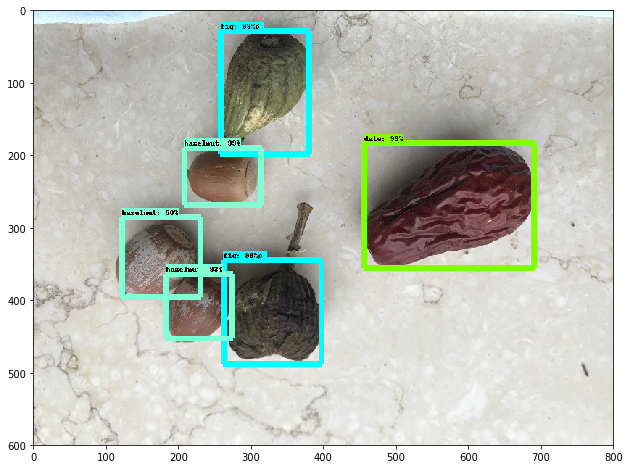

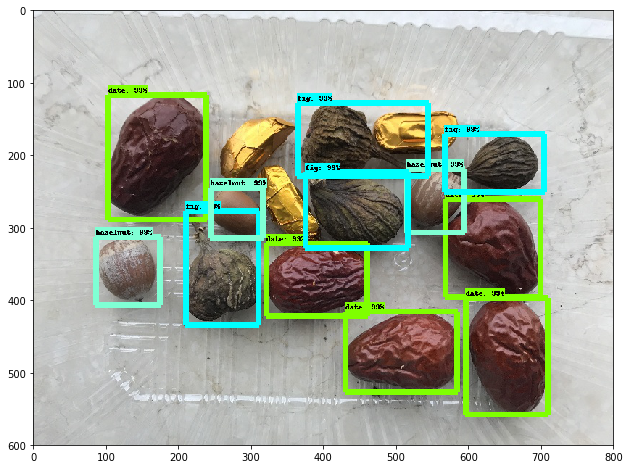

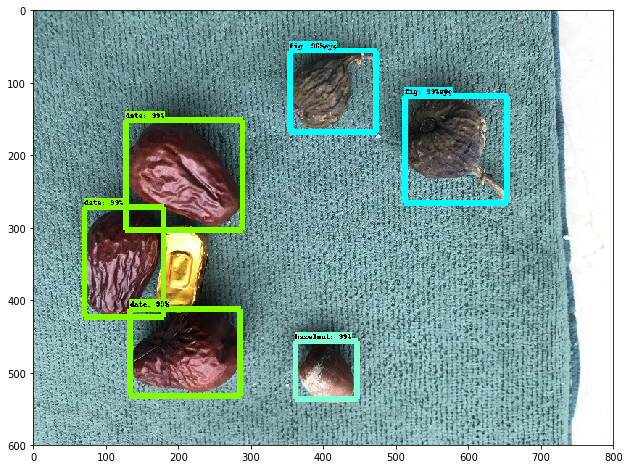

In [17]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

plt.show()